In [3]:
%load_ext autoreload
%autoreload 2

import pybnesian as bn
from causallearn.search.ConstraintBased.PC import pc

import networkx as nx
import matplotlib.pyplot as plt

import pandas as pd
from pathlib import Path
import numpy as np

import ast
import yaml
import sys
from dotenv import load_dotenv
import os

import openai
import git
from datetime import datetime
import asyncio 
import logging 

/home/kaicohrs/Repositories/causal_GPT/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
basepath = Path.cwd().parent
experiment_path = basepath.joinpath('data', 'food_insecurity')
sys.path.append('../')
from gptci import *

In [5]:
data = pd.read_csv(experiment_path.joinpath('horn_africa_food_data.csv')).astype(float)


In [6]:
#LinearCorrelation, MutualInformation, KMutualInformation, RCoT, ChiSquare, DynamicLinearCorrelation, DynamicMutualInformation, DynamicKMutualInformation, DynamicRCoT, DynamicChiSquare
test = bn.MutualInformation(data)
pc = bn.PC()

/home/kaicohrs/Repositories/causal_GPT/env/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [68]:
test.pvalue('enso', 'spi', [])

0.9041771711038425

In [36]:
graph = pc.estimate(test)

In [37]:
print(f"arcs: {graph.arcs()}")
print(f"edges : {graph.edges()}")

arcs: [('population', 'sorghum_production'), ('livestock_prices', 'population'), ('enso', 'gam_norm'), ('fatalities', 'enso'), ('food_prices', 'enso'), ('livestock_prices', 'enso'), ('idp_drought', 'livestock_prices'), ('water_prices', 'livestock_prices'), ('enso', 'livestock_prices'), ('spi', 'livestock_prices'), ('spi', 'food_prices'), ('enso', 'food_prices'), ('gam_norm', 'population'), ('gam_norm', 'food_prices'), ('food_prices', 'water_prices'), ('livestock_prices', 'water_prices')]
edges : [('spi', 'idp_drought'), ('spi', 'fatalities')]


In [7]:
def render_output(graph, variables):
    # Create a directed graph
    G = nx.DiGraph()

    for node in variables:
        G.add_node(node)

    # Add nodes and edges to the graph
    G.add_edges_from(graph.arcs())
    G.add_edges_from(graph.edges())
    G.add_edges_from([(b,a) for (a,b) in graph.edges()])
    
    # Draw the graph
    pos = nx.circular_layout(G)  # You can choose different layout algorithms
    nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_size=8, arrowsize=15)

    # Display the graph
    plt.show()

In [8]:
render_output(graph)

NameError: name 'graph' is not defined

In [9]:
def test_prop(n_no, n_yes, n, null = "YES", alpha = 0.05):
    p_no = n_no / n # prop of no
    p_yes = n_yes / n # prop of yes
    p = (n_no + n_yes) / (2*n) # pooled prop 
    se = np.sqrt( p * (1 - p) * 2 / n) # standard error 
    if null == "YES":  
        answ = "YES"
        pval = norm.sf((p_no - p_yes) / se) # p_no - p_yes >> 0 is extreme for null == "YES" 
        if pval <= alpha:
            answ = "NO"
    if null == "NO":
        answ = "NO"
        pval = norm.sf((p_yes - p_no) / se) # p_yes - p_no >> 0 is extreme for null == "NO" 
        if pval <= alpha:
            answ = "YES"
    return answ, pval

In [10]:
# Design a new test
from pybnesian import IndependenceTest

class HybridGPTIndependenceTest(IndependenceTest):
    def __init__(self, data_info, pre_stored_file, gpt_variables = None, data_driven_test=None, method = "vot", null = "YES", test_list=None):
        # IMPORTANT: Always call the parent class to initialize the C++ object.
        IndependenceTest.__init__(self)
        self.data_info = data_info
        self.null = null
        self.data_driven_test = data_driven_test
        self.gpt_variables = gpt_variables
        self.test_list = []
        self.method=method
        
        # extract variable names from data dictionary
        self.variables = [var['name'] for var in self.data_info['variables']]
        self.pre_stored_file = pre_stored_file
        self.current_level = -1 # value for level-wise increase with gpt queries
            
    def num_variables(self):
        return len(self.variables)

    def variable_names(self):
        return self.variables

    def has_variables(self, vars):
        return set(vars).issubset(set(self.variables))

    def name(self, index):
        return self.variables[index]

    def pvalue(self, x, y, z):
        # Make sure that z is a list
        if isinstance(z, str):
            z = [z]
        if z is None:
            z = []
        
        # check if one of the strings in x+y+z is in gpt_variables
        if len(set(z+[x]+[y]) & set(self.gpt_variables)) > 0:        
            
            rowXY = self.pre_stored_file.loc[(self.pre_stored_file['x'] == x) & (self.pre_stored_file['y'] == y) & (np.array([set(Z) for Z in self.pre_stored_file['z']]) ==set(z))]
            rowYX = self.pre_stored_file.loc[(self.pre_stored_file['y'] == x) & (self.pre_stored_file['x'] == y) & (np.array([set(Z) for Z in self.pre_stored_file['z']]) ==set(z))]
            # union of both dataframes
            row = pd.concat([rowXY, rowYX])

            if len(row) >= 1:
                if len(row) > 1:
                    print(f"Warning: more than one row found in pre-stored file for statement {x} indep {y} given {z}. Average output reponse.")
        
                n_no = row['n_no'].sum()
                n_yes = row['n_yes'].sum()
                nn = row['n'].sum()
                
                if self.method == "stat":
                    answ, pval = test_prop(n_no, n_yes, nn, null = self.null, alpha = 0.05)
                    if answ == "NO":
                        return 0
                    if answ == "YES":
                        return 1

                if self.method == "vot":
                    if n_no > n_yes:
                        # NO wins voting, not independent, significant evidence against conditional independence
                        return 0
                    if n_yes >  n_no:
                        # YES wins voting, independent, or rather no significant evidence against conditional independence
                        return 1
                    if n_yes == n_no:
                        if self.null == "YES":
                            return 1
                        if self.null == "NO":
                            return 0

                if self.method == "wvot":
                    return 0
                    ##TODO
                        
            if row.empty:
                if self.current_level != -1 and len(z) > self.current_level:
                    return 0
                else:
                    self.test_list.append({'x': x, 'y': y, "z": z})     
                    self.current_level = len(z)
                    return 1
        else:
            return self.data_driven_test.pvalue(x,y,z)
            


In [11]:
with open(experiment_path.joinpath('horn_africa_food_info.yaml')) as file:
    data_info = yaml.safe_load(file)

for v in data_info['variables']:
    print("{name}: {description}".format(**v))
variables = [v['name'] for v in data_info['variables']]

n = 1
enso_parent = list(((v, 'enso') for v in variables if v != 'enso'))
spi_parent = list(((v, 'spi') for v in variables if v not in ['enso', 'spi']))
black_list = enso_parent + spi_parent

with open(experiment_path.joinpath('horn_africa_food_black_list.yaml'), 'w') as yaml_file:
    yaml.dump(black_list, yaml_file, default_flow_style=False)

gpt_variables = ['enso']

# read relevant files:
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.util.logger.setLevel(logging.WARNING)


with open(experiment_path.joinpath('horn_africa_food_black_list.yaml')) as file:
    black_list = yaml.load(file, Loader=yaml.FullLoader)

with open(experiment_path.joinpath('horn_africa_food_listed.yaml')) as file:
    listed = yaml.load(file, Loader=yaml.FullLoader)

data = pd.read_csv(experiment_path.joinpath("horn_africa_food_data.csv")).astype(float)


enso: El Nino Southern Oscillation - To account for climate variability we collect data on ENSO from the World Meteorological Organization (WMO). ENSO phases are then categorized according to the Oceanic El Niño Index (ONI), which is based on a 3-month running mean of Sea Surface Temperature (SST) anomaly in the Niño 3.4 region, considered to be the most sensitive region to fluctuations, duration, and magnitude of ENSO events.
spi: Precipitation - Standardized Precipitation Index to characterize dry spells
fatalities: Violent Conflict - Proxy based on recorded fatalities
food_prices: Market prices of staple food
livestock_prices: Market prices of livestock
water_prices: Market prices of water
sorghum_production: Yield - Shorghum yield production
idp_drought: Drought Displacement - Drought-induced internal displacement.
population: Population - Population of Somalian districts.
cred_plus_rem_norm: Received Cash - Number of individuals that received cash.
gam_norm: Global Acute Malnutrit

✔  [██████████████████��█████████████████████] 100% :00s] Finished PC!less


/home/kaicohrs/Repositories/causal_GPT/env/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


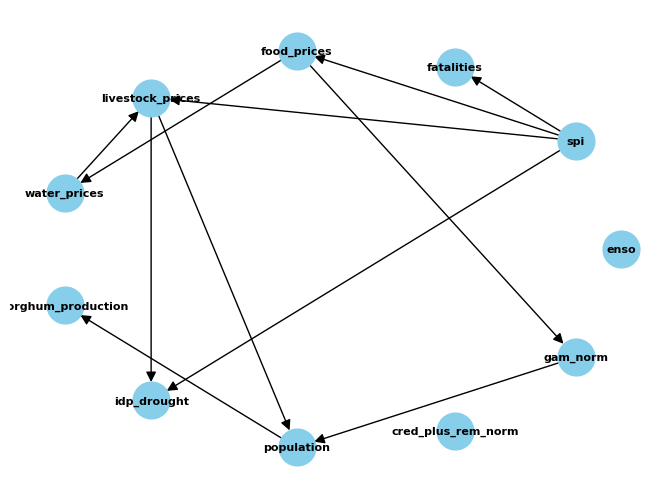

---------------------------
To be tested: [{'x': 'enso', 'y': 'spi', 'z': []}, {'x': 'enso', 'y': 'fatalities', 'z': []}, {'x': 'enso', 'y': 'food_prices', 'z': []}, {'x': 'enso', 'y': 'livestock_prices', 'z': []}, {'x': 'enso', 'y': 'water_prices', 'z': []}, {'x': 'enso', 'y': 'sorghum_production', 'z': []}, {'x': 'enso', 'y': 'idp_drought', 'z': []}, {'x': 'enso', 'y': 'population', 'z': []}, {'x': 'enso', 'y': 'cred_plus_rem_norm', 'z': []}, {'x': 'enso', 'y': 'gam_norm', 'z': []}]
Current level: 0
---------------------------
listed ci statements in the data file


100%|██████████| 20/20 [00:00<00:00, 4511.22it/s]

total task executed: 20



/tmp/ipykernel_62061/1842157746.py:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pre_stored_file = pd.concat([pre_stored_file, cisdf], ignore_index=True)


In [12]:
for i in range(1):
    pre_stored_file = pd.read_csv(experiment_path.joinpath('predictions.csv'), index_col=0)
    pre_stored_file['z'].fillna('[]', inplace=True)
    pre_stored_file['z'] = pre_stored_file['z'].apply(lambda x: ast.literal_eval(x))

    with open(experiment_path.joinpath('horn_africa_food_listed.yaml')) as file:
        listed = yaml.load(file, Loader=yaml.FullLoader)
    
    # while listed is not empty
    pc = bn.PC()
    data_driven_test = bn.MutualInformation(data)

    gptcit = HybridGPTIndependenceTest(data_info, pre_stored_file = pre_stored_file, gpt_variables = gpt_variables, data_driven_test=data_driven_test, method='vot')
    graph = pc.estimate(gptcit, verbose=True, allow_bidirected = False, arc_blacklist=black_list)
    render_output(graph, variables)
    
    # Example list
    test_list = gptcit.test_list
    print("---------------------------")
    print(f"To be tested: {test_list}")
    print(f"Current level: {gptcit.current_level}")

    # Write the list to the YAML file
    with open(experiment_path.joinpath('horn_africa_food_listed.yaml'), 'w') as yaml_file:
        yaml.dump(test_list, yaml_file, default_flow_style=False)
        
    with open(experiment_path.joinpath('horn_africa_food_listed.yaml')) as file:
        listed = yaml.load(file, Loader=yaml.FullLoader)
        

    print("---------------------------")
    print("listed ci statements in the data file")
    listed_cis = test_list
    cis = []
    for ci in listed_cis:
        ci.update({"type":"listed"})
        cis.append(ci)
        cis.append({'x':ci['y'], 'y':ci['x'], 'z':ci['z'], 'type':'listed'})
    
    ### tmstamp and git hash 
    tmstp = str(datetime.now())
    repo = git.Repo(search_parent_directories=True)
    sha = repo.head.object.hexsha

    # get results 
    results = await gpt_cis(cis, data_info,
            model="gpt-3.5-turbo",
            n=n,
            temperature=0.6, tdelay = 0,
            dryrun = True, verbose = False)
        
    ## append results to cis 
    for i in range(len(cis)):
        result = results[i][0] #generate_random_dict(n) # = 
        
        cis[i].update(result)
        cis[i].update({"sha" : sha, "tmstmp" : tmstp, 
                        "model" : "gpt-3.5-turbo", "temperature" : 0.6}) 

    ######### prepare final results
    cisdf = pd.DataFrame(cis)
    pre_stored_file = pd.concat([pre_stored_file, cisdf], ignore_index=True)
    pre_stored_file.to_csv(experiment_path.joinpath('predictions.csv'))



In [117]:
listed_cis

[]

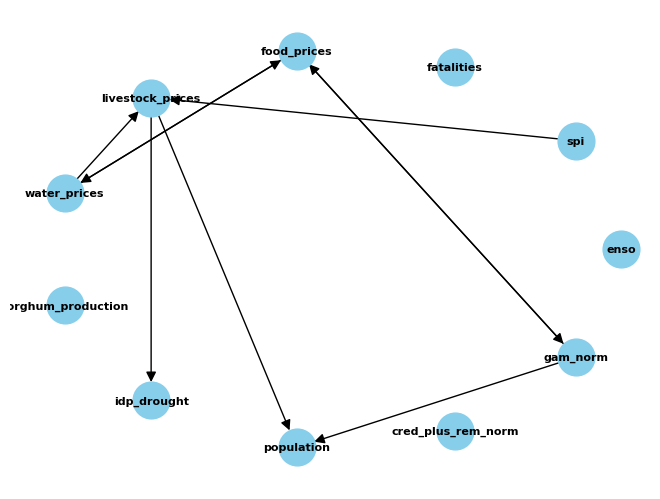

In [91]:
render_output(graph, variables)

In [48]:
vars

<function vars>

In [95]:
import random
import numpy as np

def generate_random_dict(n):
    # Generate random values
    pred = 'NO' #random.choice(['YES', 'NO'])
    wpred = 'NO' #random.choice(['YES', 'NO'])
    n_no = 1 #random.randint(0, n)
    n_yes = 0 #n - n_no
    n_total = n
    no_conf = random.uniform(0, 1)
    yes_conf = random.uniform(0, 1)
    sum_rep_no_conf = random.uniform(0, 1)
    sum_rep_yes_conf = random.uniform(0, 1)
    
    # Calculate averages, std, median, and quartiles
    avg_rep_conf = (sum_rep_no_conf + sum_rep_yes_conf) / 2
    avg_rep_no_conf = sum_rep_no_conf / max(n_no, 1)
    avg_rep_yes_conf = sum_rep_yes_conf / max(n_yes, 1)
    
    std_rep_conf = np.std([sum_rep_no_conf, sum_rep_yes_conf])
    std_rep_no_conf = np.std([sum_rep_no_conf])
    std_rep_yes_conf = np.std([sum_rep_yes_conf])
    
    med_rep_conf = np.median([sum_rep_no_conf, sum_rep_yes_conf])
    med_rep_no_conf = np.median([sum_rep_no_conf])
    med_rep_yes_conf = np.median([sum_rep_yes_conf])
    
    q25_rep_conf = np.percentile([sum_rep_no_conf, sum_rep_yes_conf], 25)
    q25_rep_no_conf = np.percentile([sum_rep_no_conf], 25)
    q25_rep_yes_conf = np.percentile([sum_rep_yes_conf], 25)
    
    q75_rep_conf = np.percentile([sum_rep_no_conf, sum_rep_yes_conf], 75)
    q75_rep_no_conf = np.percentile([sum_rep_no_conf], 75)
    q75_rep_yes_conf = np.percentile([sum_rep_yes_conf], 75)
    
    # Create the dictionary
    random_dict = {
        'pred': pred,
        'wpred': wpred,
        'n_no': n_no,
        'n_yes': n_yes,
        'n': n_total,
        'no_conf': no_conf,
        'yes_conf': yes_conf,
        'sum_rep_no_conf': sum_rep_no_conf,
        'sum_rep_yes_conf': sum_rep_yes_conf,
        'avg_rep_conf': avg_rep_conf,
        'avg_rep_no_conf': avg_rep_no_conf,
        'avg_rep_yes_conf': avg_rep_yes_conf,
        'std_rep_conf': std_rep_conf,
        'std_rep_no_conf': std_rep_no_conf,
        'std_rep_yes_conf': std_rep_yes_conf,
        'med_rep_conf': med_rep_conf,
        'med_rep_no_conf': med_rep_no_conf,
        'med_rep_yes_conf': med_rep_yes_conf,
        'q25_rep_conf': q25_rep_conf,
        'q25_rep_no_conf': q25_rep_no_conf,
        'q25_rep_yes_conf': q25_rep_yes_conf,
        'q75_rep_conf': q75_rep_conf,
        'q75_rep_no_conf': q75_rep_no_conf,
        'q75_rep_yes_conf': q75_rep_yes_conf
    }
    
    return random_dict

In [8]:
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

openai.util.logger.setLevel(logging.WARNING)

print("---------------------------")
print("listed ci statements in the data file")
listed_cis = test_list
cis = []
for ci in listed_cis:
    ci.update({"type":"listed"})
cis = cis + listed_cis
    
### tmstamp and git hash 
tmstp = str(datetime.now())
repo = git.Repo(search_parent_directories=True)
sha = repo.head.object.hexsha

## get results 
results = await gpt_cis(cis, data_info,
        model="gpt-3.5-turbo",
        n=1,
        temperature=0.6, tdelay = 0,
        dryrun = False, verbose = False)
    
## append results to cis 
for i in range(len(cis)):
    
    cis[i].update(results[i][0])
    cis[i].update({"sha" : sha, "tmstmp" : tmstp, 
                    "model" : "gpt-3.5-turbo", "temperature" : 0.6}) 

######### prepare final results
cisdf = pd.DataFrame(cis)
predictions = pre_stored_file.append(cisdf, ignore_index=True)


---------------------------
listed ci statements in the data file


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]

total task executed: 10


AttributeError: 'DataFrame' object has no attribute 'append'

In [15]:
pre_stored_file

,Unnamed: 0,x,y,z,answ,pred,wpred,n_no,n_yes,n,...,med_rep_conf,med_rep_no_conf,med_rep_yes_conf,q25_rep_conf,q25_rep_no_conf,q25_rep_yes_conf,q75_rep_conf,q75_rep_no_conf,q75_rep_yes_conf,data


In [16]:
predictions = pd.concat([pre_stored_file, cisdf], ignore_index=True)

/tmp/ipykernel_41962/4240338880.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predictions = pd.concat([pre_stored_file, cisdf], ignore_index=True)


In [123]:
with open(experiment_path.joinpath('horn_africa_food_listed.yaml')) as file:
    listed = yaml.load(file, Loader=yaml.FullLoader)

In [118]:
gptcit.test_list

[('enso', 'spi', []),
 ('enso', 'fatalities', []),
 ('enso', 'food_prices', []),
 ('enso', 'livestock_prices', []),
 ('enso', 'water_prices', []),
 ('enso', 'sorghum_production', []),
 ('enso', 'idp_drought', []),
 ('enso', 'population', []),
 ('enso', 'cred_plus_rem_norm', []),
 ('enso', 'gam_norm', [])]

In [86]:
data_info
data_driven_test
gpt_variables = None
method = "vot"
null = "YES"
pre_stored_file=None